In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import roc_curve, roc_auc_score
 

loading precomputed roc-auc

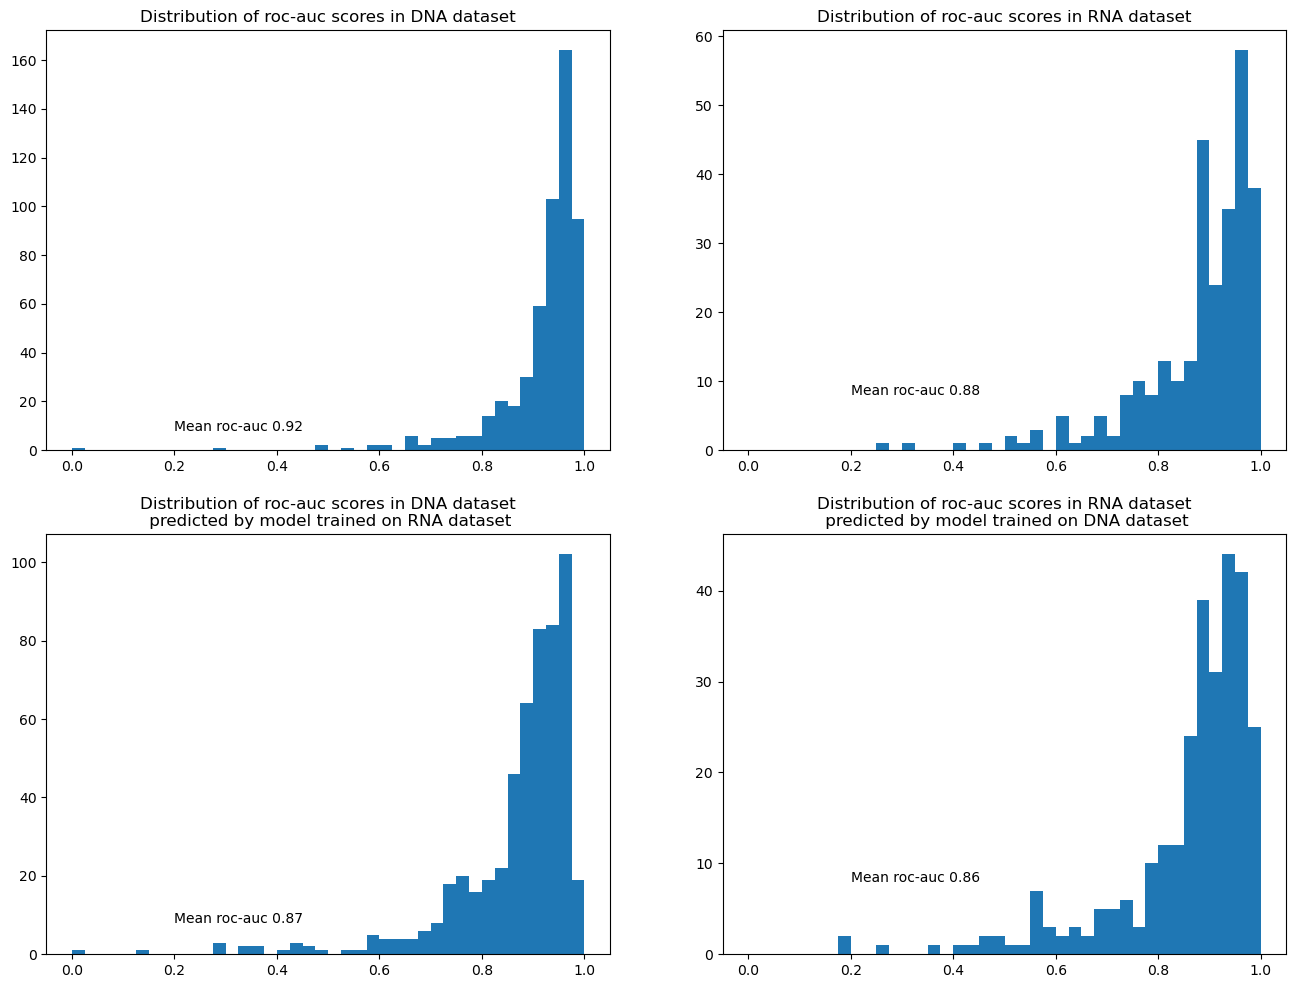

In [3]:
plt.figure(figsize=(16,12))
inf_data_dna=pd.read_csv('logs/log_inference_dna_site.txt', sep=' ', skiprows=1, usecols=[0,2,4], header=None)
inf_data_dna.columns=['name','roc','loss']
plt.subplot(221)
plt.title('Distribution of roc-auc scores in DNA dataset')
plt.hist(inf_data_dna.roc, bins=40,range=(0,1))
plt.text(s="Mean roc-auc {:.2f}".format(np.mean(inf_data_dna.roc)), y=8, x=0.2)
inf_data_rna=pd.read_csv('logs/log_inference_rna_site.txt', sep=' ', skiprows=1, usecols=[0,2,4], header=None)
inf_data_rna.columns=['name','roc','loss']
plt.subplot(222)
plt.title('Distribution of roc-auc scores in RNA dataset')
plt.hist(inf_data_rna.roc, bins=40,range=(0,1))
plt.text(s="Mean roc-auc {:.2f}".format(np.mean(inf_data_rna.roc)), y=8, x=0.2)
inf_data_dna_cross=pd.read_csv('logs/log_inference_cross_dna_site.txt', sep=' ', skiprows=1, usecols=[0,2,4], header=None)
inf_data_dna_cross.columns=['name','roc','loss']
plt.subplot(223)
plt.title('Distribution of roc-auc scores in DNA dataset\n predicted by model trained on RNA dataset')
plt.hist(inf_data_dna_cross.roc, bins=40,range=(0,1))
plt.text(s="Mean roc-auc {:.2f}".format(np.mean(inf_data_dna_cross.roc)), y=8, x=0.2)
inf_data_rna_cross=pd.read_csv('logs/log_inference_cross_rna_site.txt', sep=' ', skiprows=1, usecols=[0,2,4], header=None)
inf_data_rna_cross.columns=['name','roc','loss']
plt.subplot(224)
plt.title('Distribution of roc-auc scores in RNA dataset\n predicted by model trained on DNA dataset')
plt.hist(inf_data_rna_cross.roc, bins=40,range=(0,1))
plt.text(s="Mean roc-auc {:.2f}".format(np.mean(inf_data_rna_cross.roc)), y=8, x=0.2)
plt.savefig("images/site_hists.pdf",format="pdf")
plt.show()

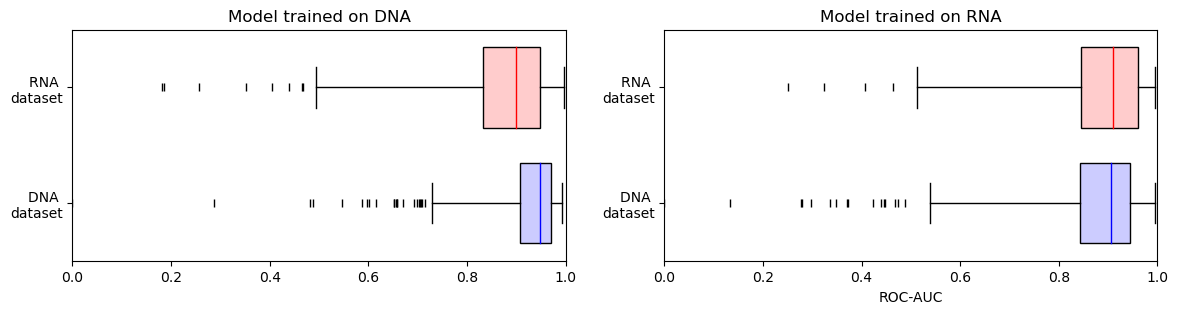

In [53]:
plt.figure(figsize=(14,3))
plt.subplot(121)
plt.title('Model trained on DNA')
plt.xlim(0,1)
box=plt.boxplot([inf_data_dna.roc,
             inf_data_rna_cross.roc], 
            labels=['DNA \ndataset', 'RNA \ndataset' ],
            whis=3, vert=0, widths=.7,patch_artist=True, flierprops=dict(marker='|'))
box['medians'][0].set_color('blue')
box['boxes'][0].set_facecolor('#CCCCFF')
box['medians'][1].set_color('red')
box['boxes'][1].set_facecolor('#FFCCCC')

plt.subplot(122)
plt.xlabel('ROC-AUC')
plt.title('Model trained on RNA')
plt.xlim(0,1)
box=plt.boxplot([inf_data_dna_cross.roc,
             inf_data_rna.roc], 
            labels=['DNA \ndataset', 'RNA \ndataset' ],
            whis=3, vert=0, widths=.7,patch_artist=True, flierprops=dict(marker='|'))
box['medians'][0].set_color('blue')
box['boxes'][0].set_facecolor('#CCCCFF')
box['medians'][1].set_color('red')
box['boxes'][1].set_facecolor('#FFCCCC')
plt.savefig("images/trans_boxes.pdf",format="pdf", bbox_inches='tight',pad_inches=0)
plt.show()

In [5]:
dna_cross_mws, dna_cross_mwp=stats.mannwhitneyu(inf_data_dna.roc, 
                   inf_data_rna_cross.roc, 
                   alternative='greater')
print(f'Mann-Whitney test for model trained on DNA: statistics {dna_cross_mws}, p-value {dna_cross_mwp}')
rna_cross_mws, rna_cross_mwp=stats.mannwhitneyu(inf_data_rna.roc, 
                   inf_data_dna_cross.roc, 
                   alternative='greater')
print(f'Mann-Whitney test for model trained on RNA: statistics {rna_cross_mws}, p-value {rna_cross_mwp}')

Mann-Whitney test for model trained on DNA: statistics 104388.0, p-value 2.475891269864913e-16
Mann-Whitney test for model trained on RNA: statistics 85421.0, p-value 0.009896366213034209


In [6]:
import json
import collections


with open('lists/dnaprot_polymer_info.json', 'r') as f:
    polymer_info_dna=json.load(f)
pfam_info_dna = collections.defaultdict(list)
for n in polymer_info_dna:
    for k in polymer_info_dna[n]:
        pfam_info_dna[k].append(n)
        
pfam_list_dna=list(pfam_info_dna.keys())
pfam_len_dna={x: len(list(set(pfam_info_dna[x]))) for x in pfam_info_dna.keys()}
    
with open('lists/rnaprot_polymer_info.json', 'r') as f:
    polymer_info_rna=json.load(f)
pfam_info_rna = collections.defaultdict(list)
for n in polymer_info_rna:
    for k in polymer_info_rna[n]:
        pfam_info_rna[k].append(n)
        
pfam_list_rna=list(pfam_info_rna.keys())
pfam_len_rna={x: len(list(set(pfam_info_rna[x]))) for x in pfam_info_rna.keys()}



In [7]:
inf_data_dna['pfams']=np.full(inf_data_dna.shape[0], None)
inf_data_dna['uniq']=np.full(inf_data_dna.shape[0], max(pfam_len_dna.values()))

inf_data_rna['pfams']=np.full(inf_data_rna.shape[0], None)
inf_data_rna['uniq']=np.full(inf_data_rna.shape[0], max(pfam_len_rna.values()))

for i in inf_data_dna.index:
    inf_data_dna.pfams[i]=polymer_info_dna.get(inf_data_dna.loc[i]['name'][:4])
    if len(inf_data_dna.pfams[i])>0:
        inf_data_dna.uniq[i]=max([pfam_len_dna[x] for x in inf_data_dna.pfams[i]])
        
for i in inf_data_rna.index:
    inf_data_rna.pfams[i]=polymer_info_rna.get(inf_data_rna.loc[i]['name'][:4])
    if len(inf_data_rna.pfams[i])>0:
        inf_data_rna.uniq[i]=max([pfam_len_rna[x] for x in inf_data_rna.pfams[i]])

/home/domain/data/prog/miniconda3/envs/dmasif/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/domain/data/prog/miniconda3/envs/dmasif/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/domain/data/prog/miniconda3/envs/dmasif/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [8]:
with open('aptamers.list', 'r') as f:
    aptamers=f.read().split('\n')
inf_data_dna['is_aptamer']=inf_data_dna.name.apply(lambda x: x[:4] in aptamers)
inf_data_rna['is_aptamer']=inf_data_rna.name.apply(lambda x: x[:4] in aptamers)


In [9]:
inf_data_dna['pdb_id']=inf_data_dna.name.apply(lambda x: x.split('_')[0])
inf_data_rna['pdb_id']=inf_data_rna.name.apply(lambda x: x.split('_')[0])

In [10]:
clusters=[]
pdb_id='pdb_id'
i='clust_size'
with open('lists/testing_dna.cdhit.clstr', 'r') as f:
    for s in f.readlines():
        if s[:8]=='>Cluster':
            clusters.append([pdb_id,i])
            i=0
            pdb_id=''
        elif s.strip()[-1]=='*':
            pdb_id=s.split('>')[1].split('_')[0]
        else:
            i+=1
    clusters.append([pdb_id,i])
clusters=pd.DataFrame(data=clusters[1:],columns=clusters[0])
clusters=clusters.groupby(by='pdb_id').max()
inf_data_dna=inf_data_dna.join(clusters, on='pdb_id')

In [11]:
clusters=[]
pdb_id='pdb_id'
i='clust_size'
with open('lists/testing_rna.cdhit.clstr', 'r') as f:
    for s in f.readlines():
        if s[:8]=='>Cluster':
            clusters.append([pdb_id,i])
            i=0
            pdb_id=''
        elif s.strip()[-1]=='*':
            pdb_id=s.split('>')[1].split('_')[0]
        else:
            i+=1
    clusters.append([pdb_id,i])
clusters=pd.DataFrame(data=clusters[1:],columns=clusters[0])
clusters=clusters.groupby(by='pdb_id').max()
inf_data_rna=inf_data_rna.join(clusters, on='pdb_id')

In [12]:
task_name='binary_dna_atomnet_v_mp_epoch48'
inf_data_dna['results']=inf_data_dna.name.apply(lambda x: 
                        np.load(f'preds/{task_name}/{"_".join(x.split("_")[:2])}_predfeatures_emb1.npy'))
inf_data_rna_cross['results']=inf_data_rna_cross.name.apply(lambda x: 
                        np.load(f'preds/{task_name}/{"_".join(x.split("_")[:2])}_predfeatures_emb1.npy'))

In [13]:
task_name='binary_rna_atomnet_v_mp_epoch49'
inf_data_rna['results']=inf_data_rna.name.apply(lambda x: 
                        np.load(f'preds/{task_name}/{"_".join(x.split("_")[:2])}_predfeatures_emb1.npy'))
inf_data_dna_cross['results']=inf_data_dna_cross.name.apply(lambda x: 
                        np.load(f'preds/{task_name}/{"_".join(x.split("_")[:2])}_predfeatures_emb1.npy'))

In [14]:
binary=True

In [15]:
if binary:
    inf_data_dna['roc_curve']=inf_data_dna.results.apply(lambda x: roc_curve(x[:,-1],x[:,-2]))
    inf_data_rna['roc_curve']=inf_data_rna.results.apply(lambda x: roc_curve(x[:,-1],x[:,-2]))

else:
    inf_data_dna['roc_curve']=inf_data_dna.results.apply(lambda x: [roc_curve(x[:,-1]==i,x[:,-6+i]) for i in range(5)])
    inf_data_rna['roc_curve']=inf_data_rna.results.apply(lambda x: [roc_curve(x[:,-1]==i,x[:,-6+i]) for i in range(5)])


/home/domain/data/prog/miniconda3/envs/dmasif/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


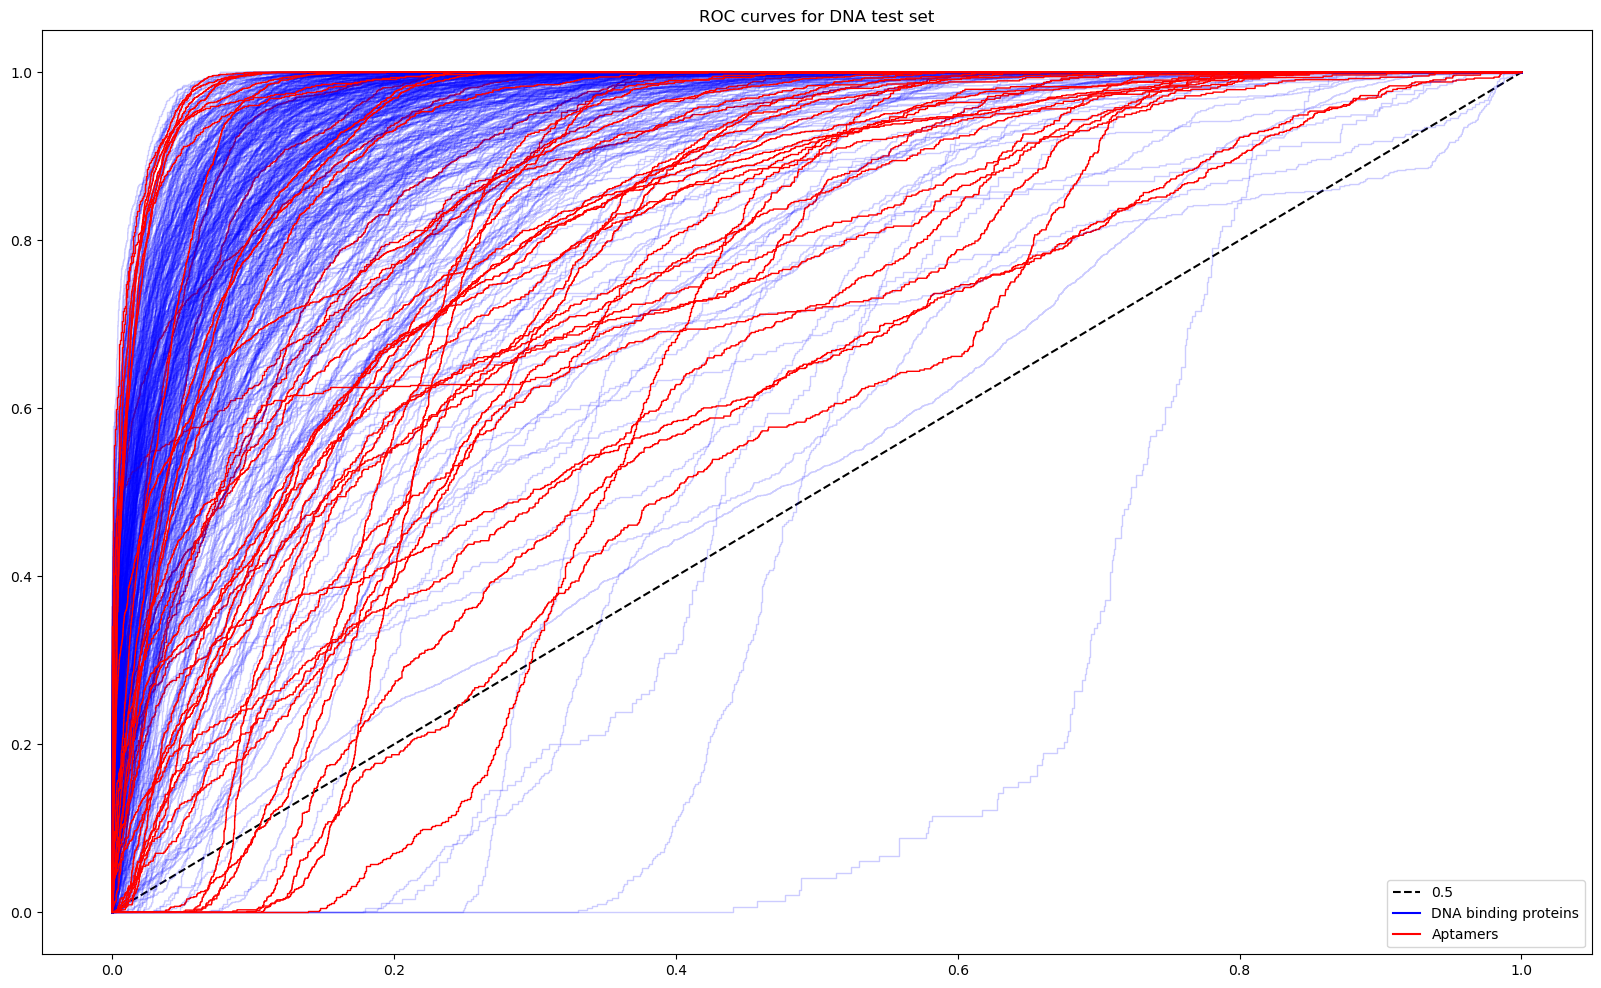

In [16]:

labels=['0','A','G','C','T']

if binary:
    plt.figure(figsize=(20,12))

    plt.title('ROC curves for DNA test set')
    plt.plot([0, 1], [0, 1],linestyle="--", color='black')
    for k in range(inf_data_dna.shape[0]):
        if inf_data_dna.loc[k]['is_aptamer']:
            cl='red'
            ap=1
        else:
            cl='blue'  
            ap=0.2
        plt.plot(inf_data_dna.roc_curve.loc[k][0],inf_data_dna.roc_curve.loc[k][1],
                 color=cl,linewidth=1,alpha=ap)
        custom_lines = [Line2D([0], [0], linestyle='--', color='black'),
                        Line2D([0], [0], color='blue'),
                        Line2D([0], [0], color='red')]
        plt.legend(custom_lines,['0.5','DNA binding proteins', 'Aptamers' ])
else:
    plt.figure(figsize=(20,12))
    for i in range(5):
        plt.subplot(231+i)
        for k in range(inf_data_dna.shape[0]):
            if inf_data_dna.loc[k]['is_aptamer']:
                cl='red'
                ap=1
            else:
                cl='blue'  
                ap=0.1
            plt.title('ROC-AUC '+labels[i])
            plt.plot(inf_data_dna.roc_curve.loc[k][0],inf_data_dna.roc_curve.loc[k][i][1],
                     color=cl,linewidth=1,alpha=ap)
        plt.plot([0, 1], [0, 1],linestyle="--", color='black')
    plt.show()


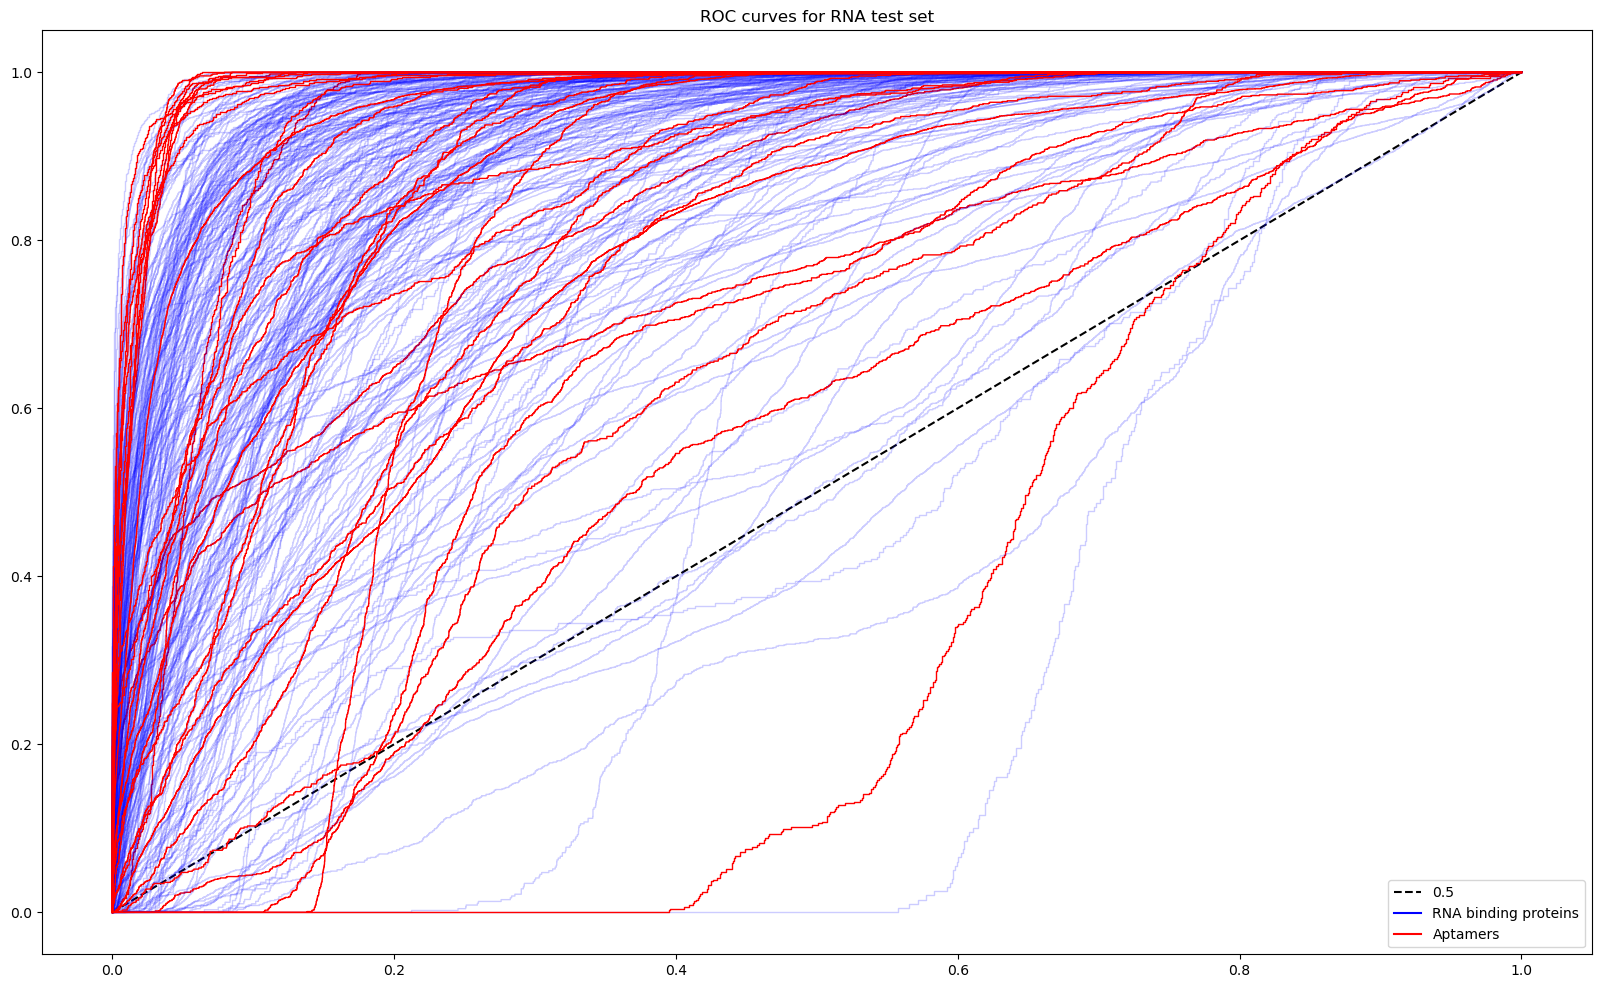

In [17]:
labels=['0','A','G','C','U']

if binary:
    plt.figure(figsize=(20,12))

    plt.title('ROC curves for RNA test set')
    plt.plot([0, 1], [0, 1],linestyle="--", color='black')
    for k in range(inf_data_rna.shape[0]):
        if inf_data_rna.loc[k]['is_aptamer']:
            cl='red'
            ap=1
        else:
            cl='blue'  
            ap=0.2
        plt.plot(inf_data_rna.roc_curve.loc[k][0],inf_data_rna.roc_curve.loc[k][1],
                 color=cl,linewidth=1,alpha=ap)
        custom_lines = [Line2D([0], [0], linestyle='--', color='black'),
                        Line2D([0], [0], color='blue'),
                        Line2D([0], [0], color='red')]
        plt.legend(custom_lines,['0.5','RNA binding proteins', 'Aptamers' ])
else:
    plt.figure(figsize=(20,12))
    for i in range(5):
        plt.subplot(231+i)
        for k in range(inf_data_rna.shape[0]):
            if inf_data_rna.loc[k]['is_aptamer']:
                cl='red'
                ap=1
            else:
                cl='blue'  
                ap=0.1
            plt.title('ROC-AUC '+labels[i])
            plt.plot(inf_data_rna.roc_curve.loc[k][0],inf_data_rna.roc_curve.loc[k][i][1],
                     color=cl,linewidth=1,alpha=ap)
        plt.plot([0, 1], [0, 1],linestyle="--", color='black')
    plt.show()


In [18]:
inf_data_dna['iou']=inf_data_dna.results.apply(
                lambda x: np.sum((x[:,-2]>=0.5)&(x[:,-1]==1))/np.sum((x[:,-2]>=0.5)|(x[:,-1]==1)))
inf_data_rna['iou']=inf_data_rna.results.apply(
                lambda x: np.sum((x[:,-2]>=0.5)&(x[:,-1]==1))/np.sum((x[:,-2]>=0.5)|(x[:,-1]==1)))
inf_data_dna_cross['iou']=inf_data_dna_cross.results.apply(
                lambda x: np.sum((x[:,-2]>=0.5)&(x[:,-1]==1))/np.sum((x[:,-2]>=0.5)|(x[:,-1]==1)))
inf_data_rna_cross['iou']=inf_data_rna_cross.results.apply(
                lambda x: np.sum((x[:,-2]>=0.5)&(x[:,-1]==1))/np.sum((x[:,-2]>=0.5)|(x[:,-1]==1)))

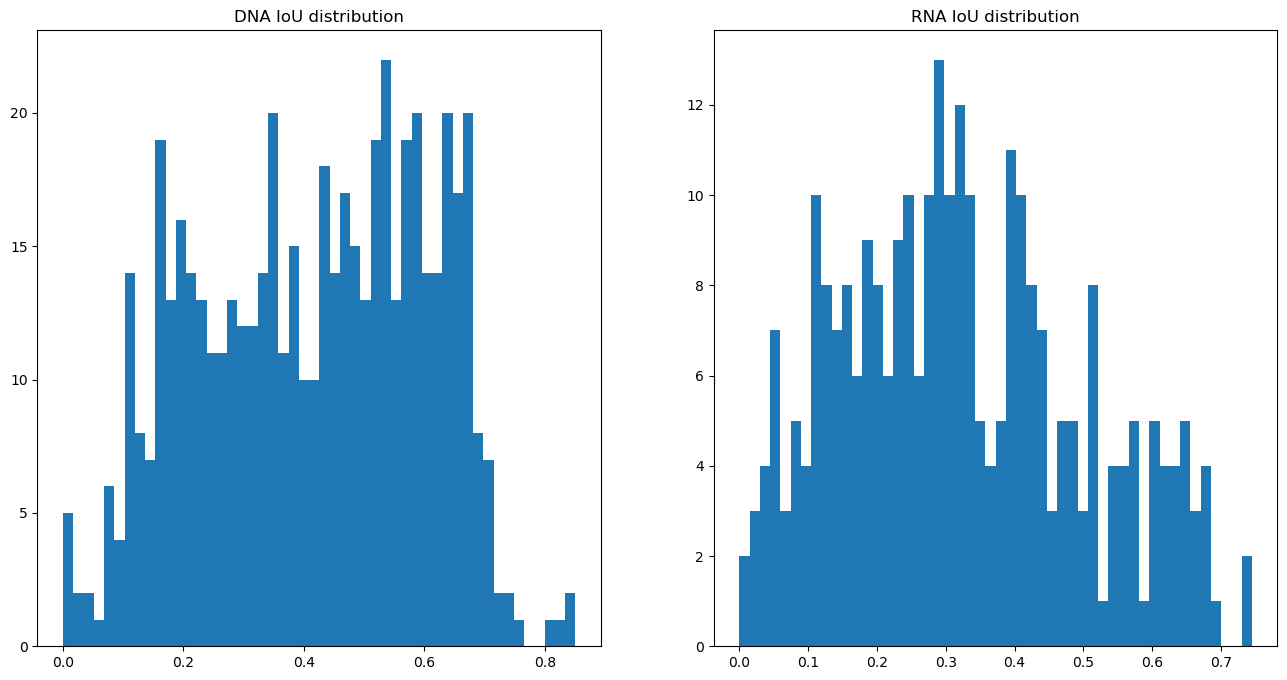

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('DNA IoU distribution')
plt.hist(inf_data_dna['iou'], bins=50)
plt.subplot(122)
plt.title('RNA IoU distribution')
plt.hist(inf_data_rna['iou'], bins=50)
plt.show()

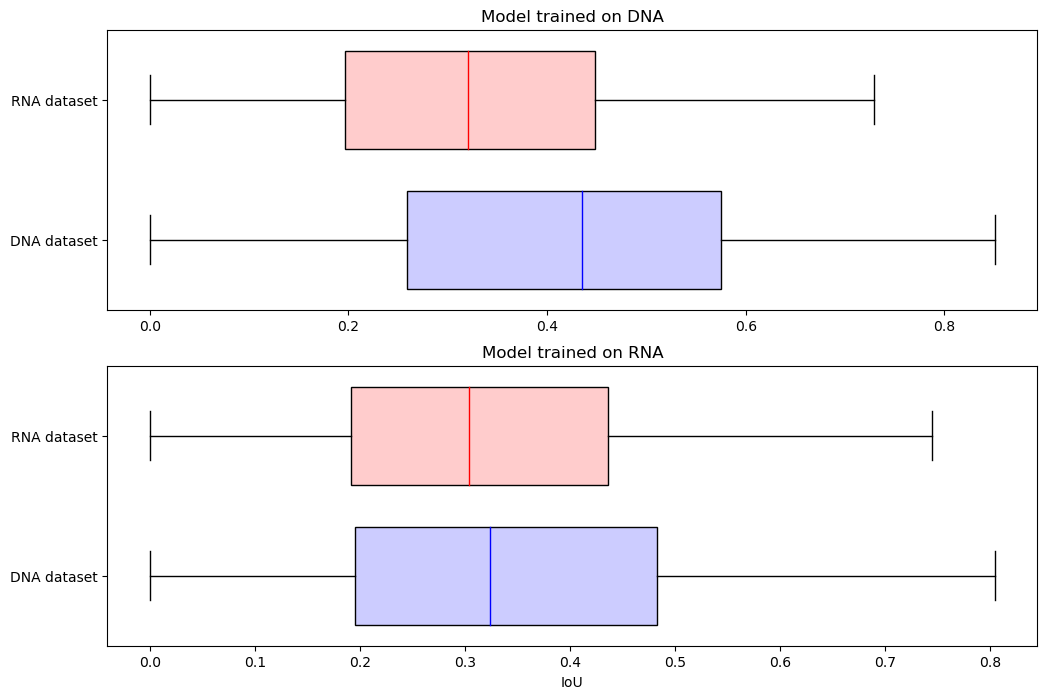

In [20]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.title('Model trained on DNA')
#plt.xlim(0,1)
box=plt.boxplot([inf_data_dna.iou,
             inf_data_rna_cross.iou], 
            labels=['DNA dataset', 'RNA dataset' ],
            whis=3, vert=0, widths=.7,patch_artist=True, flierprops=dict(marker='|'))
box['medians'][0].set_color('blue')
box['boxes'][0].set_facecolor('#CCCCFF')
box['medians'][1].set_color('red')
box['boxes'][1].set_facecolor('#FFCCCC')

plt.subplot(212)
plt.xlabel('IoU')
plt.title('Model trained on RNA')
#plt.xlim(0,1)
box=plt.boxplot([inf_data_dna_cross.iou,
             inf_data_rna.iou], 
            labels=['DNA dataset', 'RNA dataset' ],
            whis=3, vert=0, widths=.7,patch_artist=True, flierprops=dict(marker='|'))
box['medians'][0].set_color('blue')
box['boxes'][0].set_facecolor('#CCCCFF')
box['medians'][1].set_color('red')
box['boxes'][1].set_facecolor('#FFCCCC')

In [21]:
inf_data_dna['acc']=inf_data_dna.results.apply(
                lambda x: np.mean((x[:,-2]>=0.5)==(x[:,-1]==1)))
inf_data_rna['acc']=inf_data_rna.results.apply(
                lambda x: np.mean((x[:,-2]>=0.5)==(x[:,-1]==1)))
inf_data_dna_cross['acc']=inf_data_dna_cross.results.apply(
                lambda x: np.mean((x[:,-2]>=0.5)==(x[:,-1]==1)))
inf_data_rna_cross['acc']=inf_data_rna_cross.results.apply(
                lambda x: np.mean((x[:,-2]>=0.5)==(x[:,-1]==1)))

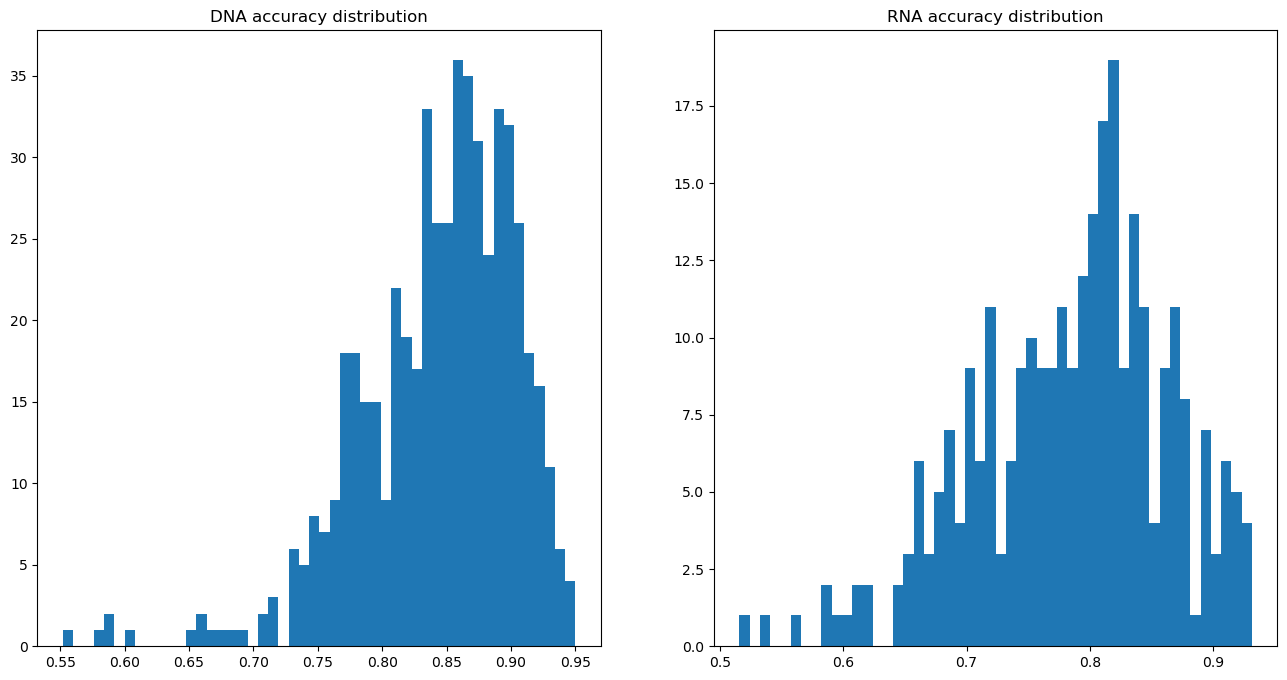

In [22]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('DNA accuracy distribution')
plt.hist(inf_data_dna['acc'], bins=50)
plt.subplot(122)
plt.title('RNA accuracy distribution')
plt.hist(inf_data_rna['acc'], bins=50)
plt.show()

In [23]:
print('\nDifference between aptamers and NA-binding\n')
dna_ts, dna_tp=stats.ttest_ind(inf_data_dna[~inf_data_dna.is_aptamer].roc, 
                inf_data_dna[inf_data_dna.is_aptamer].roc, 
                equal_var=False, alternative='greater')
print(f'T-test for DNA dataset: statistics {dna_ts}, p-value {dna_tp}')
dna_mws, dna_mwp=stats.mannwhitneyu(inf_data_dna[~inf_data_dna.is_aptamer].roc, 
                   inf_data_dna[inf_data_dna.is_aptamer].roc, 
                   alternative='greater')
print(f'Mann-Whitney test for DNA dataset: statistics {dna_mws}, p-value {dna_mwp}')
dna_kss, dna_ksp=stats.ks_2samp(inf_data_dna[~inf_data_dna.is_aptamer].roc, 
                   inf_data_dna[inf_data_dna.is_aptamer].roc, 
                   alternative='greater')
print(f'Kolmogorov-Smirnov test for DNA dataset: statistics {dna_kss}, p-value {dna_ksp}')

rna_ts, rna_tp=stats.ttest_ind(inf_data_rna[~inf_data_rna.is_aptamer].roc, 
                inf_data_rna[inf_data_rna.is_aptamer].roc, 
                equal_var=False, alternative='greater')
print(f'T-test for RNA dataset: statistics {rna_ts}, p-value {rna_tp}')

rna_mws, rna_mwp=stats.mannwhitneyu(inf_data_rna[~inf_data_rna.is_aptamer].roc, 
                   inf_data_rna[inf_data_rna.is_aptamer].roc, 
                   alternative='greater')
print(f'Mann-Whitney test for RNA dataset: statistics {rna_mws}, p-value {rna_mwp}')

rna_kss, rna_ksp=stats.ks_2samp(inf_data_rna[~inf_data_rna.is_aptamer].roc, 
                   inf_data_rna[inf_data_rna.is_aptamer].roc, 
                   alternative='greater')
print(f'Kolmogorov-Smirnov test for RNA dataset: statistics {rna_kss}, p-value {rna_ksp}')

print('\nDifference between non-redundant and redundant sequences on 90% identity\n')

dna_ts_r, dna_tp_r=stats.ttest_ind(inf_data_dna[inf_data_dna.clust_size>0].roc, 
                inf_data_dna[inf_data_dna.clust_size==0].roc, 
                equal_var=False, alternative='greater')
print(f'T-test for DNA dataset: statistics {dna_ts_r}, p-value {dna_tp_r}')
dna_mws_r, dna_mwp_r=stats.mannwhitneyu(inf_data_dna[inf_data_dna.clust_size>0].roc, 
                   inf_data_dna[inf_data_dna.clust_size==0].roc, 
                   alternative='greater')
print(f'Mann-Whitney test for DNA dataset: statistics {dna_mws_r}, p-value {dna_mwp_r}')
dna_kss_r, dna_ksp_r=stats.ks_2samp(inf_data_dna[inf_data_dna.clust_size>0].roc, 
                   inf_data_dna[inf_data_dna.clust_size==0].roc, 
                   alternative='greater')
print(f'Kolmogorov-Smirnov test for DNA dataset: statistics {dna_kss_r}, p-value {dna_ksp_r}')

rna_ts_r, rna_tp_r=stats.ttest_ind(inf_data_rna[inf_data_rna.clust_size>0].roc, 
                inf_data_rna[inf_data_rna.clust_size==0].roc, 
                equal_var=False, alternative='greater')
print(f'T-test for RNA dataset: statistics {rna_ts_r}, p-value {rna_tp_r}')

rna_mws_r, rna_mwp_r=stats.mannwhitneyu(inf_data_rna[inf_data_rna.clust_size>0].roc, 
                   inf_data_rna[inf_data_rna.clust_size==0].roc, 
                   alternative='greater')
print(f'Mann-Whitney test for RNA dataset: statistics {rna_mws_r}, p-value {rna_mwp_r}')
rna_kss_r, rna_ksp_r=stats.ks_2samp(inf_data_rna[inf_data_rna.clust_size>0].roc, 
                   inf_data_rna[inf_data_rna.clust_size==0].roc, 
                   alternative='greater')
print(f'Kolmogorov-Smirnov test for RNA dataset: statistics {rna_kss_r}, p-value {rna_ksp_r}')


Difference between aptamers and NA-binding

T-test for DNA dataset: statistics 4.595779666856364, p-value 1.7636772342616042e-05
Mann-Whitney test for DNA dataset: statistics 14794.0, p-value 5.302420513330877e-06
Kolmogorov-Smirnov test for DNA dataset: statistics 0.11866666666666667, p-value 0.30938133256276185
T-test for RNA dataset: statistics 0.6044692865445411, p-value 0.2748528072642811
Mann-Whitney test for RNA dataset: statistics 3683.0, p-value 0.6557939886623689
Kolmogorov-Smirnov test for RNA dataset: statistics 0.2710765239948119, p-value 0.015327733222402815

Difference between non-redundant and redundant sequences on 90% identity

T-test for DNA dataset: statistics 4.639300348170153, p-value 2.6241000585702895e-06
Mann-Whitney test for DNA dataset: statistics 43946.0, p-value 9.59361665733011e-07
Kolmogorov-Smirnov test for DNA dataset: statistics 0.013410502540937324, p-value 0.9429496818521803
T-test for RNA dataset: statistics 2.426699415499831, p-value 0.00804361883

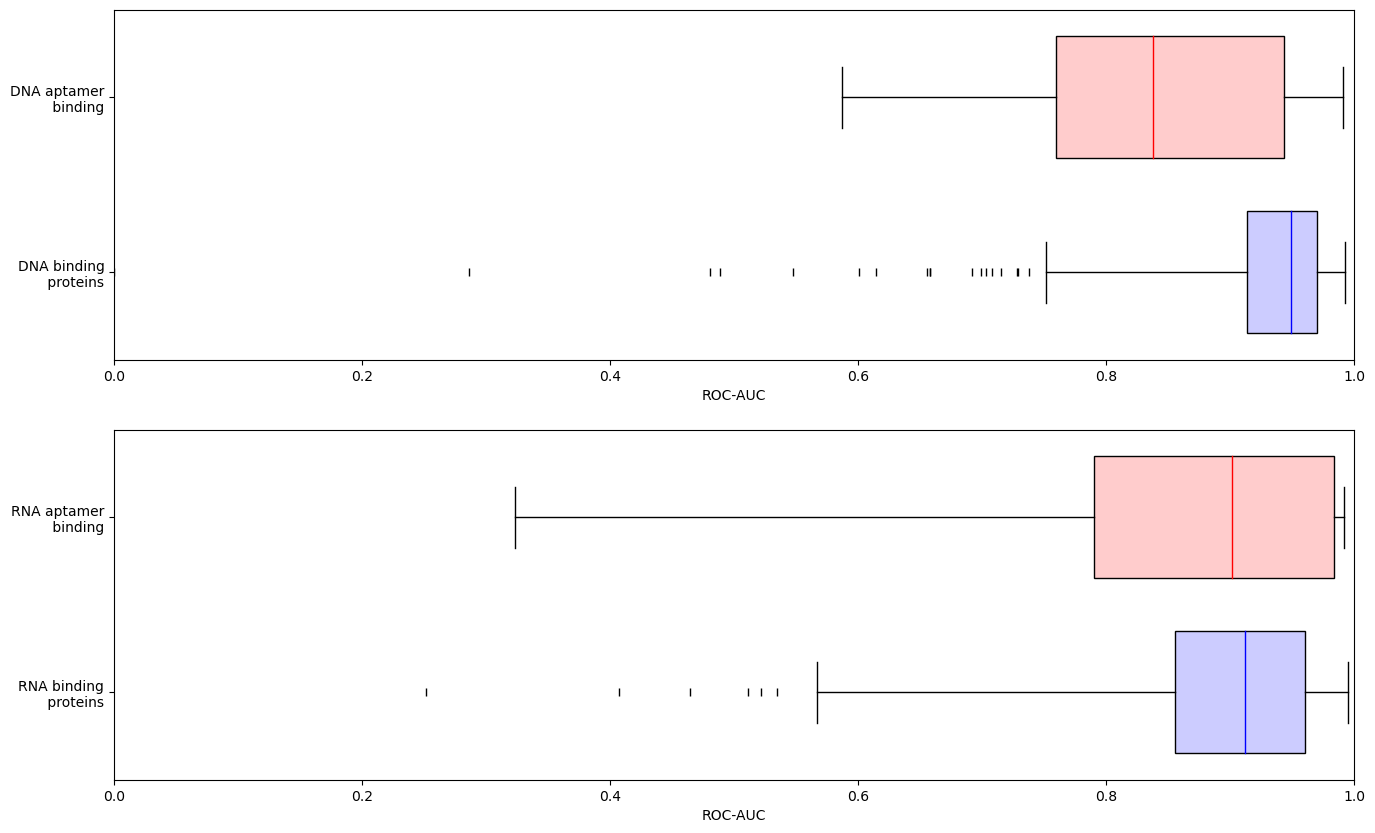

In [161]:
plt.figure(figsize=(16,10))
plt.title('Comparison of roc-auc scores in aptamer and natural NA binding proteins')
plt.subplot(222)
plt.xlim(0,1)
plt.xlabel('ROC-AUC')
box=plt.boxplot([inf_data_dna[~inf_data_dna.is_aptamer].roc,
             inf_data_dna[inf_data_dna.is_aptamer].roc], 
            labels=['DNA binding\n proteins', 'DNA aptamer\n binding' ],
            whis=3, vert=0, widths=.7,patch_artist=True, flierprops=dict(marker='|'))
box['medians'][0].set_color('blue')
box['boxes'][0].set_facecolor('#CCCCFF')
box['medians'][1].set_color('red')
box['boxes'][1].set_facecolor('#FFCCCC')
#plt.text(s="Kolmogorov-Smirnov test: statistics {:.2f}, p-value {:.5e}".format(dna_kss,dna_ksp), y=1.5, x=0.1)

plt.subplot(221)
plt.xlabel('ROC-AUC')
plt.ylabel('Density')
plt.hist(inf_data_dna[~inf_data_dna.is_aptamer].roc, bins=50, alpha=0.5, density=True, color='blue', range=(0,1))     
plt.hist(inf_data_dna[inf_data_dna.is_aptamer].roc, bins=50, alpha=0.5, density=True, color='red', range=(0,1))
plt.legend(labels=['DNA binding proteins', 'DNA aptamer\n binding' ])
#plt.text(s='T-test: statistics {:.5f}, p-value {:.5e}'.format(dna_ts,dna_tp), y=8, x=0.2)

plt.subplot(224)
plt.xlim(0,1)
plt.xlabel('ROC-AUC')
box=plt.boxplot([inf_data_rna[~inf_data_rna.is_aptamer].roc,
             inf_data_rna[inf_data_rna.is_aptamer].roc], 
            labels=['RNA binding\n proteins', 'RNA aptamer\n binding' ],
            whis=3, vert=0, widths=.7,patch_artist=True, flierprops=dict(marker='|'))
box['medians'][0].set_color('blue')
box['boxes'][0].set_facecolor('#CCCCFF')
box['medians'][1].set_color('red')
box['boxes'][1].set_facecolor('#FFCCCC')
#plt.text(s="Kolmogorov-Smirnov test: statistics {:.2f}, p-value {:.5e}".format(rna_kss,rna_ksp), y=1.5, x=0.1)

plt.subplot(223)
plt.xlabel('ROC-AUC')
plt.ylabel('Density')

plt.hist(inf_data_rna[~inf_data_rna.is_aptamer].roc, bins=50, alpha=0.5, density=True, color='blue', range=(0,1))     
plt.hist(inf_data_rna[inf_data_rna.is_aptamer].roc, bins=50, alpha=0.5, density=True, color='red', range=(0,1))
plt.legend(labels=['RNA binding proteins', 'RNA aptamer\n binding' ])
#plt.text(s="T-test: statistics {:.2f}, p-value {:.5e}".format(rna_ts,rna_tp), y=8, x=0.2)
plt.savefig("images/aptamer_boxes.pdf",format="pdf")

plt.show()


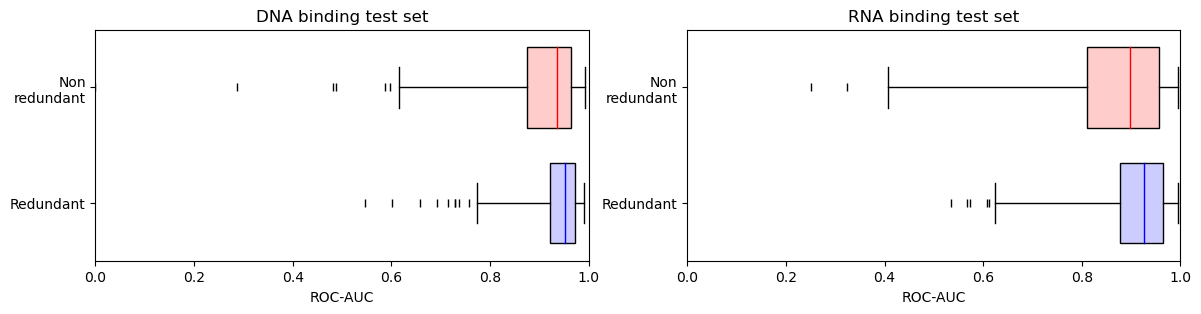

In [54]:
plt.figure(figsize=(14,3))
plt.subplot(121)
plt.title('DNA binding test set')
plt.xlabel('ROC-AUC')
plt.xlim(0,1)
box=plt.boxplot([inf_data_dna[inf_data_dna.clust_size>0].roc,
             inf_data_dna[inf_data_dna.clust_size==0].roc], 
            labels=['Redundant', 'Non\nredundant' ],
            whis=3, vert=0, widths=.7,patch_artist=True, flierprops=dict(marker='|'))
box['medians'][0].set_color('blue')
box['boxes'][0].set_facecolor('#CCCCFF')
box['medians'][1].set_color('red')
box['boxes'][1].set_facecolor('#FFCCCC')
#plt.text(s="Kolmogorov-Smirnov test: statistics {:.2f}, p-value {:.5e}".format(dna_kss_r,dna_ksp_r), y=1.5, x=0.1)
'''
plt.subplot(221)
plt.title('DNA binding test set',loc='right')

plt.xlabel('ROC-AUC')
plt.ylabel('Density')
plt.hist(inf_data_dna[inf_data_dna.clust_size>0].roc, bins=50, alpha=0.5, density=True, color='blue', range=(0,1))     
plt.hist(inf_data_dna[inf_data_dna.clust_size==0].roc, bins=50, alpha=0.5, density=True, color='red', range=(0,1))
plt.legend(labels=['Redundant', 'Non-redundant' ])
#plt.text(s='T-test: statistics {:.5f}, p-value {:.5e}'.format(dna_ts_r,dna_tp_r), y=8, x=0.2)
'''

plt.subplot(122)
plt.title('RNA binding test set')
plt.xlabel('ROC-AUC')
plt.xlim(0,1)
box=plt.boxplot([inf_data_rna[inf_data_rna.clust_size>0].roc,
             inf_data_rna[inf_data_rna.clust_size==0].roc], 
            labels=['Redundant', 'Non\nredundant' ],
            whis=3, vert=0, widths=.7,patch_artist=True, flierprops=dict(marker='|'))
box['medians'][0].set_color('blue')
box['boxes'][0].set_facecolor('#CCCCFF')
box['medians'][1].set_color('red')
box['boxes'][1].set_facecolor('#FFCCCC')
#plt.text(s="Kolmogorov-Smirnov test: statistics {:.2f}, p-value {:.5e}".format(rna_kss_r,rna_ksp_r), y=1.5, x=0.1)
'''
plt.subplot(223)
plt.title('RNA binding test set',loc='right')

plt.xlabel('ROC-AUC')
plt.ylabel('Density')

plt.hist(inf_data_rna[inf_data_rna.clust_size>0].roc, bins=50, alpha=0.5, density=True, color='blue', range=(0,1))     
plt.hist(inf_data_rna[inf_data_rna.clust_size==0].roc, bins=50, alpha=0.5, density=True, color='red', range=(0,1))
plt.legend(labels=['Redundant', 'Non-redundant'  ])
#plt.text(s="T-test: statistics {:.2f}, p-value {:.5e}".format(rna_ts_r,rna_tp_r), y=5, x=0.2)
'''
plt.savefig("images/redundant_boxes.pdf",format="pdf", bbox_inches='tight',pad_inches=0)

plt.show()


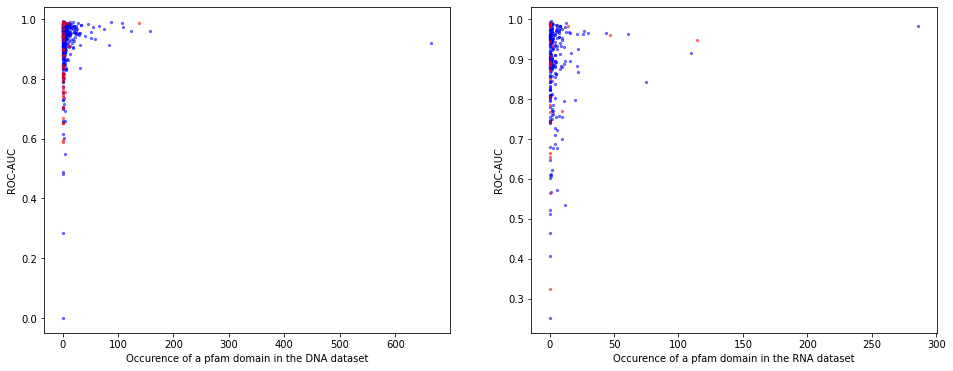

In [15]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.xlabel('Occurence of a pfam domain in the DNA dataset')
plt.ylabel('ROC-AUC')

plt.scatter(inf_data_dna[~inf_data_dna.is_aptamer].clust_size,
             inf_data_dna[~inf_data_dna.is_aptamer].roc, s=5, alpha=0.5, color='blue')
plt.scatter(inf_data_dna[inf_data_dna.is_aptamer].clust_size,
             inf_data_dna[inf_data_dna.is_aptamer].roc, s=5, alpha=0.5, color='red')
#plt.xscale("log")
plt.subplot(122)
plt.xlabel('Occurence of a pfam domain in the RNA dataset')
plt.ylabel('ROC-AUC')

plt.scatter(inf_data_rna[~inf_data_rna.is_aptamer].clust_size,
             inf_data_rna[~inf_data_rna.is_aptamer].roc, s=5, alpha=0.5, color='blue')
plt.scatter(inf_data_rna[inf_data_rna.is_aptamer].clust_size,
             inf_data_rna[inf_data_rna.is_aptamer].roc, s=5, alpha=0.5, color='red')
#plt.xscale("log")
plt.show()

In [25]:
np.corrcoef(inf_data_dna.roc,inf_data_dna.clust_size)[0,1]
np.corrcoef(inf_data_rna.roc,inf_data_rna.clust_size)[0,1]

0.10047393588125177

The same for nucleotide detection

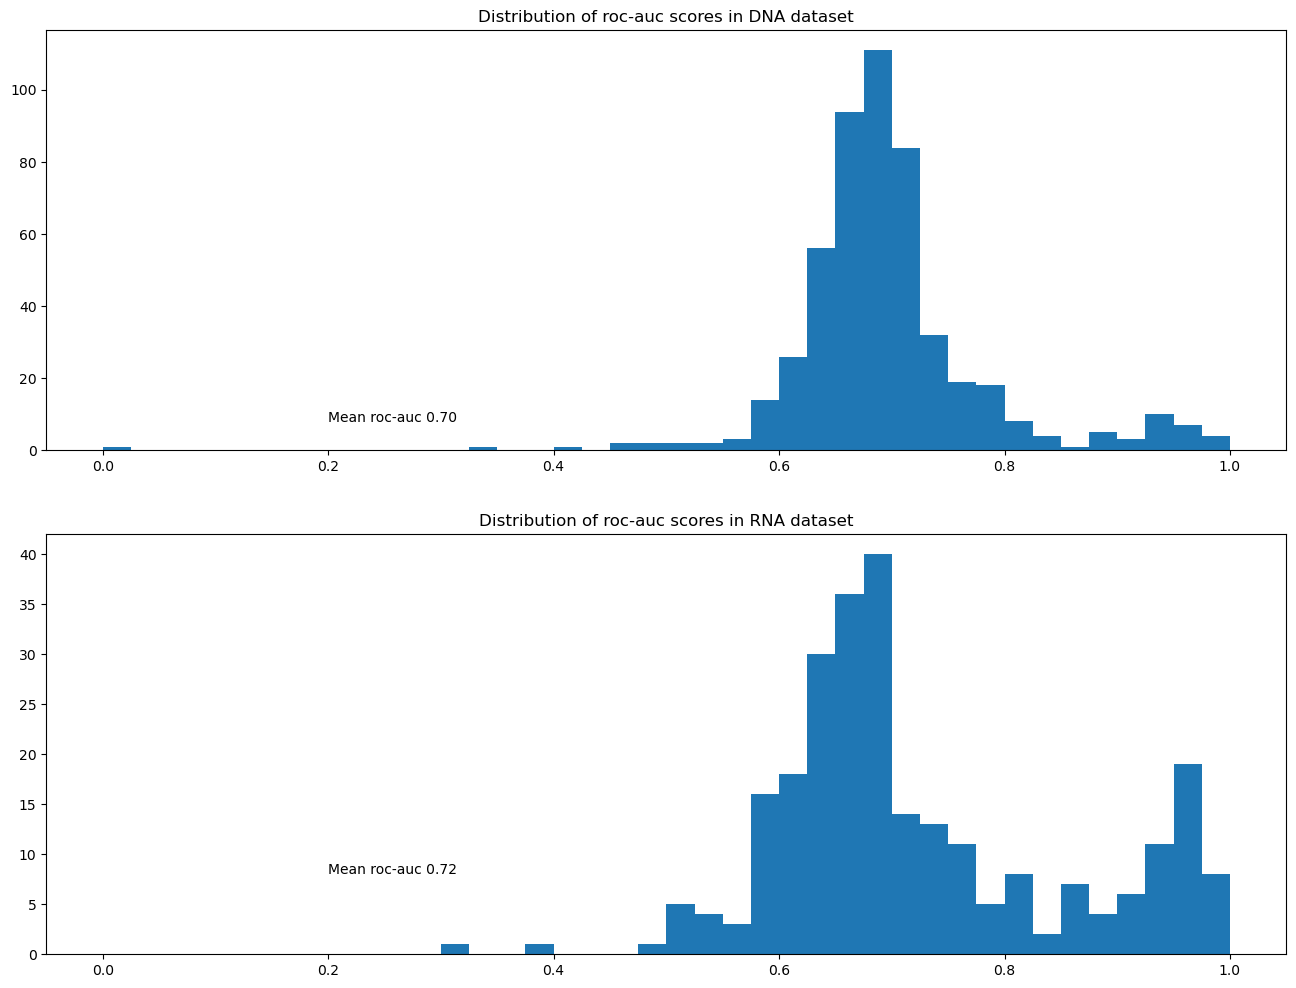

In [26]:
plt.figure(figsize=(16,12))
inf_data_dna_npi=pd.read_csv('logs/log_inference.txt', sep=' ', skiprows=1, usecols=[0,2,4], header=None)
inf_data_dna_npi.columns=['name','roc','loss']
plt.subplot(211)
plt.title('Distribution of roc-auc scores in DNA dataset')
plt.hist(inf_data_dna_npi.roc, bins=40,range=(0,1))
plt.text(s="Mean roc-auc {:.2f}".format(np.mean(inf_data_dna_npi.roc)), y=8, x=0.2)

inf_data_rna_npi=pd.read_csv('logs/log_inference_rna_npi.txt', sep=' ', skiprows=1, usecols=[0,2,4], header=None)
inf_data_rna_npi.columns=['name','roc','loss']
plt.subplot(212)
plt.title('Distribution of roc-auc scores in RNA dataset')
plt.hist(inf_data_rna_npi.roc, bins=40,range=(0,1))
plt.text(s="Mean roc-auc {:.2f}".format(np.mean(inf_data_rna_npi.roc)), y=8, x=0.2)

#plt.savefig("images/site_hists.pdf",format="pdf")
plt.show()

In [27]:
task_name='npi_atomnet_v_mp_upd_epoch43'
inf_data_dna_npi['results']=inf_data_dna_npi.name.apply(lambda x: 
                        np.load(f'preds/{task_name}/{"_".join(x.split("_")[:2])}_predfeatures_emb1.npy'))

In [28]:
task_name='rna_npi_atomnet_vmp_epoch46'
inf_data_rna_npi['results']=inf_data_rna_npi.name.apply(lambda x: 
                        np.load(f'preds/{task_name}/{"_".join(x.split("_")[:2])}_predfeatures_emb1.npy'))

In [29]:

def ovo(a,b):
    ovo=np.zeros((a.shape[1],b.shape[1]))
    for i in range(a.shape[1]):
        for j in range(b.shape[1]):
            mask=(a[:,i]==1)|(a[:,j]==1)
            try:
                ovo[i,j]=roc_auc_score(a[mask,i],b[mask,i])
            except:
                ovo[i,j]=np.nan
    return ovo

In [30]:
inf_data_dna_npi['ovo']=inf_data_dna_npi.results.apply(lambda x: ovo(x[:,-5:],x[:,-10:-5]))
inf_data_rna_npi['ovo']=inf_data_rna_npi.results.apply(lambda x: ovo(x[:,-5:],x[:,-10:-5]))


In [39]:
inf_data_dna_npi['na']='DNA'
inf_data_rna_npi['na']='RNA'

inf_data_npi=pd.concat((inf_data_dna_npi,inf_data_rna_npi))
inf_data_npi['all'] = ''

In [40]:
inf_data_npi

,name,roc,loss,results,ovo,na,all
0,7mwm_A_CD:,0.733921,0.194508,"[[0.7708087, 0.14626864, 0.47052094, 0.0549793...","[[nan, 0.9459169878496276, 0.9584706066922164,...",DNA,
1,7mtl_AB_CD:,0.659069,0.204807,"[[0.74749887, 0.12781854, 0.47428936, 0.052302...","[[nan, 0.964549748191263, 0.6068209750102417, ...",DNA,
2,7odf_A_CEG:,0.658573,0.230239,"[[0.7033006, 0.11931096, 0.4360581, 0.04626988...","[[nan, 0.7654109382869231, 0.8301369336055607,...",DNA,
3,7oa5_ABCDEFGH_IJKL:,0.675340,0.215173,"[[0.64170253, 0.098157704, 0.44923082, 0.04922...","[[nan, 0.8567633915057502, 0.8987801155915782,...",DNA,
4,7el1_A_CD:,0.642618,0.223967,"[[0.8302895, 0.17179188, 0.5082061, 0.06414913...","[[nan, 0.8915961509970175, 0.9405026968658351,...",DNA,
...,...,...,...,...,...,...,...
258,2fmt_AB_CD:,0.649277,0.222822,"[[0.79907084, 0.15641528, 0.5975282, 0.0891466...","[[nan, 0.9310023983523832, 0.8326173930554319,...",RNA,
259,1qtq_A_B:,0.695836,0.211644,"[[0.91766477, 0.21001601, 0.6346296, 0.1001687...","[[nan, 0.9073027653868995, 0.894173491654596, ...",RNA,
260,1av6_A_B:,0.800764,0.191506,"[[0.6521358, 0.10373535, 0.37502074, 0.0331714...","[[nan, 0.9312292561974282, 0.9640834951173405,...",RNA,
261,1cwp_ABC_DEF:,0.801548,0.189431,"[[0.8237472, 0.16466793, 0.495865, 0.059670914...","[[nan, 0.9502656772123036, nan, nan, 0.9680422...",RNA,


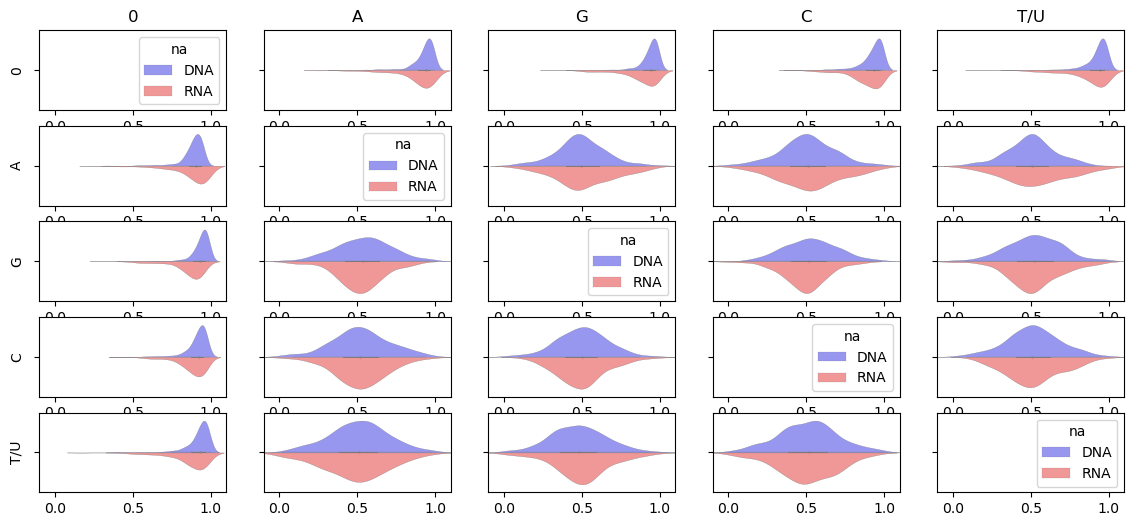

In [52]:
labels=['0','A','G','C','T/U']

fig, ax = plt.subplots(5, 5,figsize=(14,6))
for i in range(5):
    for j in range(5):
        sns.violinplot(y=inf_data_npi['all'],x=inf_data_npi.ovo.apply(lambda x: x[i,j]), 
                       hue=inf_data_npi.na, split=True, ax=ax[i,j], linewidth=0.2, 
                       palette=['#8888FF','#FF8888'])
        ax[i,j].set(xlabel=None, ylabel=None,xlim=(-0.1,1.1))  # remove the axis label
        if i==0:
            ax[i,j].set(title=labels[j])
        if j==0:
            ax[i,j].set(ylabel=labels[i])        
        if i!=j:
            ax[i,j].legend([], [], frameon=False)
fig.savefig("images/npi_violins.pdf",format="pdf", bbox_inches='tight',pad_inches=0)
